In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [316]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-03 20:57:36,997 INFO: Closing external client and cleaning up certificates.


Connection closed.
2025-03-03 20:57:36,998 INFO: Initializing external client
2025-03-03 20:57:36,999 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 20:57:37,651 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214668


In [317]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1214668/featurestores/1202296/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [318]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides",
    read_options={"timeout": 1200}
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.46s) 


In [319]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [320]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-12-31 23:00:00+00:00,2,0
1,2023-12-31 23:00:00+00:00,3,0
2,2023-12-31 23:00:00+00:00,4,4
3,2023-12-31 23:00:00+00:00,5,0
4,2023-12-31 23:00:00+00:00,6,0


In [321]:
ts_data["pickup_hour"].min()

'2023-12-31 23:00:00+00:00'

In [322]:
ts_data["pickup_hour"].max()

'2023-12-31 23:00:00+00:00'

In [323]:
ts_data_copy = ts_data.copy()

In [324]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [325]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   pickup_hour         260 non-null    datetime64[ns, UTC]
 1   pickup_location_id  260 non-null    int32              
 2   rides               260 non-null    int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 4.2 KB


In [326]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [327]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         260 non-null    datetime64[ns]
 1   pickup_location_id  260 non-null    int32         
 2   rides               260 non-null    int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 4.2 KB


In [328]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [329]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 23:00:00,2,0,2023-12
1,2023-12-31 23:00:00,3,0,2023-12
2,2023-12-31 23:00:00,4,4,2023-12
3,2023-12-31 23:00:00,5,0,2023-12
4,2023-12-31 23:00:00,6,0,2023-12
...,...,...,...,...
255,2023-12-31 23:00:00,259,1,2023-12
256,2023-12-31 23:00:00,260,7,2023-12
257,2023-12-31 23:00:00,261,18,2023-12
258,2023-12-31 23:00:00,262,53,2023-12


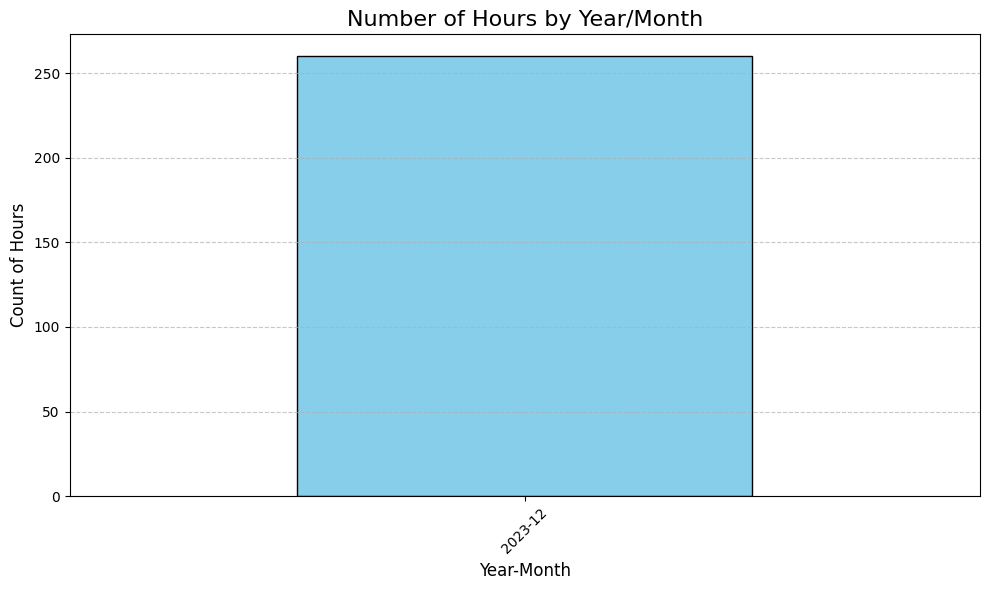

In [330]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [331]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 23:00:00,2,0,2023-12
1,2023-12-31 23:00:00,3,0,2023-12
2,2023-12-31 23:00:00,4,4,2023-12
3,2023-12-31 23:00:00,5,0,2023-12
4,2023-12-31 23:00:00,6,0,2023-12


In [332]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [333]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [334]:
filtered_data.shape

(260, 3)

In [335]:
ts_data = filtered_data

In [336]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         260 non-null    datetime64[ns]
 1   pickup_location_id  260 non-null    int32         
 2   rides               260 non-null    int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 4.2 KB


In [337]:
ts_data.head()["pickup_hour"].values

array(['2023-12-31T23:00:00.000000000', '2023-12-31T23:00:00.000000000',
       '2023-12-31T23:00:00.000000000', '2023-12-31T23:00:00.000000000',
       '2023-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [338]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

Skipping location_id 2: Not enough data to create even one window.
Skipping location_id 3: Not enough data to create even one window.
Skipping location_id 4: Not enough data to create even one window.
Skipping location_id 5: Not enough data to create even one window.
Skipping location_id 6: Not enough data to create even one window.
Skipping location_id 7: Not enough data to create even one window.
Skipping location_id 8: Not enough data to create even one window.
Skipping location_id 9: Not enough data to create even one window.
Skipping location_id 10: Not enough data to create even one window.
Skipping location_id 11: Not enough data to create even one window.
Skipping location_id 12: Not enough data to create even one window.
Skipping location_id 13: Not enough data to create even one window.
Skipping location_id 14: Not enough data to create even one window.
Skipping location_id 15: Not enough data to create even one window.
Skipping location_id 16: Not enough data to create even 

ValueError: No data could be transformed. Check if input DataFrame is empty or window size is too large.

In [ ]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,pickup_hour,pickup_location_id
0,2023-12-31 23:00:00,5
1,2023-12-31 23:00:00,44
2,2023-12-31 23:00:00,84
3,2023-12-31 23:00:00,105
4,2023-12-31 23:00:00,109
5,2023-12-31 23:00:00,110
6,2023-12-31 23:00:00,156
7,2023-12-31 23:00:00,176
8,2023-12-31 23:00:00,204


In [ ]:
features[features["pickup_location_id"] == 2]

,pickup_hour,pickup_location_id


In [ ]:
features_copy = features.copy()

In [ ]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(9, 3)

In [ ]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-03 17:06:14.300211')

In [ ]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9, 2)
(9,)
(0, 2)
(0,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         9 non-null      datetime64[ns]
 1   pickup_location_id  9 non-null      int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 236.0 bytes


In [ ]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [ ]:
pipeline.fit(features, targets)

ValueError: Missing required column: rides_t-168

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [ ]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [ ]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9355


In [ ]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\mkhaw\\github\\sp25_taxi\\models\\lgb_model.pkl']

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [ ]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('C:\\Users\\mkhaw\\github\\sp25_taxi\\models\\lgb_model.pkl')

TypeError: create_model() got an unexpected keyword argument 'include_files'

In [ ]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-02-10 22:39:54,780 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-02-10 22:39:54,790 INFO: Initializing external client
2025-02-10 22:39:54,790 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-10 22:39:55,824 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1211551

In [ ]:
from src.inference import get_model_predictions

In [ ]:
preds = get_model_predictions(model, features_copy)

In [ ]:
model.get_m

In [ ]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,86.0
91516,263,95.0
91517,263,83.0
91518,263,76.0


In [ ]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
